In [1]:
from __future__ import print_function
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

import cntk as C
import cntk.tests.test_utils
cntk.tests.test_utils.set_device_from_pytest_env()
C.cntk_py.set_fixed_random_seed(1)

%matplotlib inline

In [2]:
input_dim = 784
num_output_classes = 10

In [3]:
def create_reader(path, is_training, input_dim, num_label_classes):

    labelStream = C.io.StreamDef(field='labels', shape=num_label_classes, is_sparse=False)
    featureStream = C.io.StreamDef(field='features', shape=input_dim, is_sparse=False)

    deserailizer = C.io.CTFDeserializer(path, C.io.StreamDefs(labels = labelStream, features = featureStream))

    return C.io.MinibatchSource(deserailizer,
       randomize = is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)

In [4]:
data_dir = os.path.join("DataSets", "MNIST")

train_file = os.path.join(data_dir, "Train-28x28_cntk_text.txt")
test_file = os.path.join(data_dir, "Test-28x28_cntk_text.txt")

print("Data directory is {0}".format(data_dir))

Data directory is DataSets\MNIST


In [5]:
input = C.input_variable(input_dim)
label = C.input_variable(num_output_classes)

In [6]:
def create_model(features, no_of_hidden_neurons = 1024):
    with C.layers.default_options(init = C.glorot_uniform()):
        r = C.layers.Dense(no_of_hidden_neurons, activation = None)(features)
        r = C.layers.Dense(num_output_classes, activation = None)(r)
        return r

In [31]:
def train_network(model, learning_rate = 0.1, momentum = 0.9, max_epochs = 50, dataset_multiplier = 1):
    
    reader_train = create_reader(train_file, True, input_dim, num_output_classes)

    input_map = {
        label  : reader_train.streams.labels,
        input  : reader_train.streams.features
    }
    
    reader_test = create_reader(test_file, False, input_dim, num_output_classes)

    test_input_map = {
        label  : reader_test.streams.labels,
        input  : reader_test.streams.features,
    }

    minibatch_size = 64
    num_samples_per_sweep = 60000
    num_sweeps_to_train_with = 10
    num_minibatches_to_train = (num_samples_per_sweep * num_sweeps_to_train_with) / minibatch_size

    loss = C.cross_entropy_with_softmax(model, label)
    label_error = C.classification_error(model, label)

    # Run the trainer on and perform model training
    training_progress_output_freq = 500

    # Training Parameters
    progress_printer = C.logging.ProgressPrinter(tag='Training', num_epochs=max_epochs)
    lr_schedule = C.learning_parameter_schedule(learning_rate)
    momentums = C.momentum_schedule(momentum, minibatch_size = minibatch_size)

    learner = C.momentum_sgd(model.parameters, lr_schedule, momentum = momentums)
    trainer = C.Trainer(model, (loss, label_error), [learner], [progress_printer])

    
    plotdata = {"epoch":[], "loss":[], "error":[]}
    progress_printer = C.logging.ProgressPrinter(tag='Training', num_epochs=max_epochs)

    batch_index = 0
    for epoch in range(max_epochs):       # loop over epochs
        avg_loss = 0
        avg_error = 0
        for i in range(0, int(num_minibatches_to_train * dataset_multiplier)):

            # Read a mini batch from the training data file
            data = reader_train.next_minibatch(minibatch_size, input_map = input_map)
            trainer.train_minibatch(data)
            
            avg_loss += trainer.previous_minibatch_loss_average
            avg_error += trainer.previous_minibatch_evaluation_average

        plotdata["epoch"].append(epoch)
        plotdata["loss"].append(avg_loss / int(num_minibatches_to_train * dataset_multiplier))
        plotdata["error"].append(avg_error / int(num_minibatches_to_train * dataset_multiplier))
        trainer.summarize_training_progress()
    test_minibatch_size = 512
    num_samples = 10000
    num_minibatches_to_test = num_samples // test_minibatch_size
    test_result = 0.0

    for i in range(num_minibatches_to_test):

        data = reader_test.next_minibatch(test_minibatch_size,
                                          input_map = test_input_map)

        eval_error = trainer.test_minibatch(data)
        test_result = test_result + eval_error

    print("Average test error: {0:.2f}%".format(test_result*100 / num_minibatches_to_test))
    return plotdata

In [11]:
def plot_data(plotdata = {}):
    plt.figure()
    plt.subplot(211)
    plt.plot(plotdata["epoch"], plotdata["loss"], 'b--')
    plt.xlabel('Epoch number')
    plt.ylabel('Loss')
    plt.title('Epoch run vs. Training loss')

    plt.show()

    plt.subplot(212)
    plt.plot(plotdata["epoch"], plotdata["error"], 'r--')
    plt.xlabel('Epoch number')
    plt.ylabel('Label Prediction Error')
    plt.title('Epoch run vs. Label Prediction Error')
    plt.show()

# Expreiment 1

## Vary number of hidden units

### n = 20

Learning rate per minibatch: 0.1
Momentum per 64 samples: 0.9
Finished Epoch[1 of 50]: [Training] loss = 0.294255 * 600000, metric = 8.27% * 600000 21.676s (27680.4 samples/s);
Finished Epoch[2 of 50]: [Training] loss = 0.259850 * 600000, metric = 7.24% * 600000 22.371s (26820.4 samples/s);
Finished Epoch[3 of 50]: [Training] loss = 0.252638 * 600000, metric = 7.05% * 600000 21.603s (27773.9 samples/s);
Finished Epoch[4 of 50]: [Training] loss = 0.248612 * 600000, metric = 6.92% * 600000 22.009s (27261.6 samples/s);
Finished Epoch[5 of 50]: [Training] loss = 0.245836 * 600000, metric = 6.86% * 600000 19.360s (30991.7 samples/s);
Finished Epoch[6 of 50]: [Training] loss = 0.243621 * 600000, metric = 6.80% * 600000 19.474s (30810.3 samples/s);
Finished Epoch[7 of 50]: [Training] loss = 0.242089 * 600000, metric = 6.76% * 600000 21.559s (27830.6 samples/s);
Finished Epoch[8 of 50]: [Training] loss = 0.240363 * 600000, metric = 6.67% * 600000 25.647s (23394.5 samples/s);
Finished Epoch[9 o

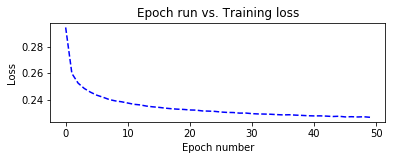

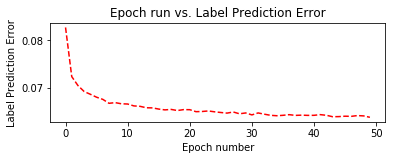

In [12]:
z1_1 = create_model(input/255.0, no_of_hidden_neurons=20)

data1_1 = train_network(z1_1)

plot_data(data1_1)

### n = 50

Learning rate per minibatch: 0.1
Momentum per 64 samples: 0.9
Finished Epoch[1 of 50]: [Training] loss = 0.291980 * 600000, metric = 8.19% * 600000 23.123s (25948.2 samples/s);
Finished Epoch[2 of 50]: [Training] loss = 0.259876 * 600000, metric = 7.24% * 600000 20.384s (29434.9 samples/s);
Finished Epoch[3 of 50]: [Training] loss = 0.252713 * 600000, metric = 7.04% * 600000 21.383s (28059.7 samples/s);
Finished Epoch[4 of 50]: [Training] loss = 0.248675 * 600000, metric = 6.92% * 600000 19.919s (30122.0 samples/s);
Finished Epoch[5 of 50]: [Training] loss = 0.245887 * 600000, metric = 6.86% * 600000 19.791s (30316.8 samples/s);
Finished Epoch[6 of 50]: [Training] loss = 0.243668 * 600000, metric = 6.81% * 600000 19.899s (30152.3 samples/s);
Finished Epoch[7 of 50]: [Training] loss = 0.242126 * 600000, metric = 6.76% * 600000 19.861s (30210.0 samples/s);
Finished Epoch[8 of 50]: [Training] loss = 0.240394 * 600000, metric = 6.68% * 600000 19.929s (30106.9 samples/s);
Finished Epoch[9 o

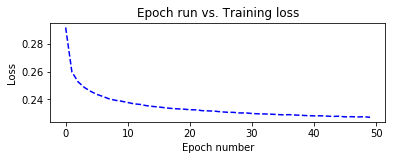

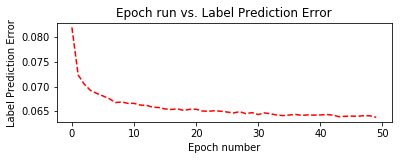

In [38]:
z1_2 = create_model(input/255.0, no_of_hidden_neurons=50)

data1_2 = train_network(z1_2)

plot_data(data1_2)

### n = 100

Learning rate per minibatch: 0.1
Momentum per 64 samples: 0.9
Finished Epoch[1 of 50]: [Training] loss = 0.291068 * 600000, metric = 8.18% * 600000 23.047s (26033.8 samples/s);
Finished Epoch[2 of 50]: [Training] loss = 0.259618 * 600000, metric = 7.24% * 600000 22.321s (26880.5 samples/s);
Finished Epoch[3 of 50]: [Training] loss = 0.252575 * 600000, metric = 7.04% * 600000 25.039s (23962.6 samples/s);
Finished Epoch[4 of 50]: [Training] loss = 0.248636 * 600000, metric = 6.92% * 600000 23.016s (26068.8 samples/s);
Finished Epoch[5 of 50]: [Training] loss = 0.245895 * 600000, metric = 6.87% * 600000 24.409s (24581.1 samples/s);
Finished Epoch[6 of 50]: [Training] loss = 0.243682 * 600000, metric = 6.81% * 600000 26.934s (22276.7 samples/s);
Finished Epoch[7 of 50]: [Training] loss = 0.242164 * 600000, metric = 6.75% * 600000 22.533s (26627.6 samples/s);
Finished Epoch[8 of 50]: [Training] loss = 0.240434 * 600000, metric = 6.68% * 600000 22.328s (26872.1 samples/s);
Finished Epoch[9 o

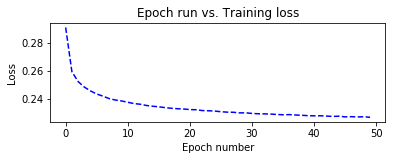

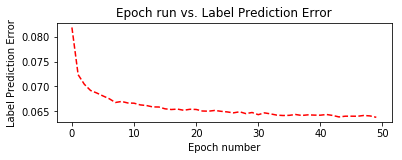

In [39]:
z1_3 = create_model(input/255.0, no_of_hidden_neurons=100)

data1_3 = train_network(z1_3)

plot_data(data1_3)

# Expreiment 2

## Vary Momentums

### momentum = 0

Learning rate per minibatch: 0.1
Momentum per 64 samples: 0.0
Finished Epoch[1 of 20]: [Training] loss = 0.291416 * 600000, metric = 8.20% * 600000 23.961s (25040.7 samples/s);
Finished Epoch[2 of 20]: [Training] loss = 0.260283 * 600000, metric = 7.26% * 600000 22.338s (26860.1 samples/s);
Finished Epoch[3 of 20]: [Training] loss = 0.253615 * 600000, metric = 7.05% * 600000 21.785s (27541.9 samples/s);
Finished Epoch[4 of 20]: [Training] loss = 0.249314 * 600000, metric = 6.95% * 600000 22.105s (27143.2 samples/s);
Finished Epoch[5 of 20]: [Training] loss = 0.246565 * 600000, metric = 6.86% * 600000 22.208s (27017.3 samples/s);
Finished Epoch[6 of 20]: [Training] loss = 0.244418 * 600000, metric = 6.82% * 600000 22.101s (27148.1 samples/s);
Finished Epoch[7 of 20]: [Training] loss = 0.242855 * 600000, metric = 6.78% * 600000 22.229s (26991.8 samples/s);
Finished Epoch[8 of 20]: [Training] loss = 0.241335 * 600000, metric = 6.70% * 600000 22.381s (26808.5 samples/s);
Finished Epoch[9 o

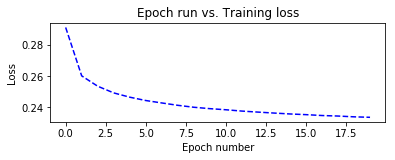

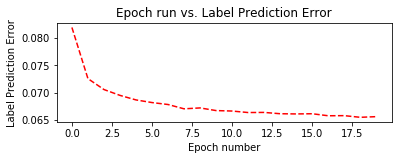

In [32]:
z2 = create_model(input/255.0, no_of_hidden_neurons=100)

data2_1 = train_network(z2, momentum = 0, max_epochs = 20)

plot_data(data2_1)

### momentum = 0.25

Learning rate per minibatch: 0.1
Momentum per 64 samples: 0.25
Finished Epoch[1 of 20]: [Training] loss = 0.290844 * 600000, metric = 8.17% * 600000 28.331s (21178.2 samples/s);
Finished Epoch[2 of 20]: [Training] loss = 0.259907 * 600000, metric = 7.23% * 600000 25.650s (23391.8 samples/s);
Finished Epoch[3 of 20]: [Training] loss = 0.253262 * 600000, metric = 7.04% * 600000 24.727s (24265.0 samples/s);
Finished Epoch[4 of 20]: [Training] loss = 0.248931 * 600000, metric = 6.93% * 600000 22.039s (27224.5 samples/s);
Finished Epoch[5 of 20]: [Training] loss = 0.246259 * 600000, metric = 6.86% * 600000 22.013s (27256.6 samples/s);
Finished Epoch[6 of 20]: [Training] loss = 0.244000 * 600000, metric = 6.81% * 600000 22.074s (27181.3 samples/s);
Finished Epoch[7 of 20]: [Training] loss = 0.242566 * 600000, metric = 6.76% * 600000 22.064s (27193.6 samples/s);
Finished Epoch[8 of 20]: [Training] loss = 0.240999 * 600000, metric = 6.69% * 600000 22.090s (27161.6 samples/s);
Finished Epoch[9 

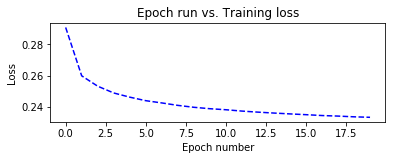

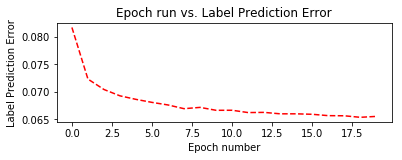

In [33]:
z2_2 = create_model(input/255.0, no_of_hidden_neurons=100)

data2_2 = train_network(z2_2, momentum = 0.25, max_epochs = 20)

plot_data(data2_2)

### momentum = 0.5

Learning rate per minibatch: 0.1
Momentum per 64 samples: 0.5
Finished Epoch[1 of 20]: [Training] loss = 0.290526 * 600000, metric = 8.16% * 600000 22.410s (26773.8 samples/s);
Finished Epoch[2 of 20]: [Training] loss = 0.259713 * 600000, metric = 7.24% * 600000 21.427s (28002.1 samples/s);
Finished Epoch[3 of 20]: [Training] loss = 0.253086 * 600000, metric = 7.03% * 600000 21.524s (27875.9 samples/s);
Finished Epoch[4 of 20]: [Training] loss = 0.248733 * 600000, metric = 6.93% * 600000 21.682s (27672.7 samples/s);
Finished Epoch[5 of 20]: [Training] loss = 0.246080 * 600000, metric = 6.85% * 600000 21.699s (27651.0 samples/s);
Finished Epoch[6 of 20]: [Training] loss = 0.243724 * 600000, metric = 6.79% * 600000 21.376s (28068.9 samples/s);
Finished Epoch[7 of 20]: [Training] loss = 0.242385 * 600000, metric = 6.77% * 600000 21.908s (27387.3 samples/s);
Finished Epoch[8 of 20]: [Training] loss = 0.240773 * 600000, metric = 6.69% * 600000 25.069s (23933.9 samples/s);
Finished Epoch[9 o

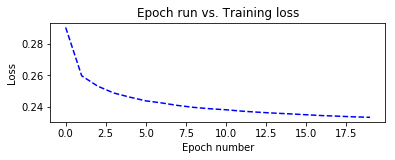

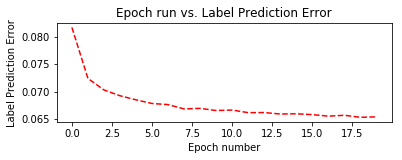

In [34]:
z2_3 = create_model(input/255.0, no_of_hidden_neurons=100)

data2_3 = train_network(z2_3, momentum = 0.5, max_epochs = 20)

plot_data(data2_3)

# Expreiment 3

## Vary Dataset Size

### dataset_size = 1/4

Learning rate per minibatch: 0.1
Momentum per 64 samples: 0.9
Finished Epoch[1 of 20]: [Training] loss = 0.341678 * 149952, metric = 9.78% * 149952 7.505s (19980.3 samples/s);
Finished Epoch[2 of 20]: [Training] loss = 0.283147 * 149952, metric = 7.94% * 149952 6.066s (24720.1 samples/s);
Finished Epoch[3 of 20]: [Training] loss = 0.271297 * 149952, metric = 7.56% * 149952 6.492s (23098.0 samples/s);
Finished Epoch[4 of 20]: [Training] loss = 0.268176 * 149952, metric = 7.46% * 149952 5.856s (25606.6 samples/s);
Finished Epoch[5 of 20]: [Training] loss = 0.264341 * 149952, metric = 7.32% * 149952 5.784s (25925.3 samples/s);
Finished Epoch[6 of 20]: [Training] loss = 0.259915 * 149952, metric = 7.26% * 149952 5.672s (26437.2 samples/s);
Finished Epoch[7 of 20]: [Training] loss = 0.257214 * 149952, metric = 7.23% * 149952 5.683s (26386.1 samples/s);
Finished Epoch[8 of 20]: [Training] loss = 0.257085 * 149952, metric = 7.14% * 149952 5.618s (26691.3 samples/s);
Finished Epoch[9 of 20]: [

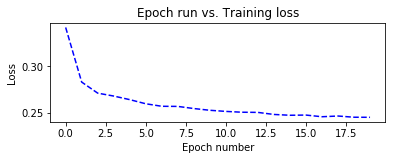

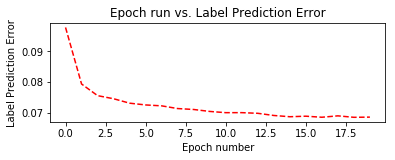

In [35]:
z3_1 = create_model(input/255.0, no_of_hidden_neurons=100)

data3_1 = train_network(z3_1, max_epochs = 20, dataset_multiplier = 1/4)

plot_data(data3_1)

### dataset_size = 1/2

Learning rate per minibatch: 0.1
Momentum per 64 samples: 0.9
Finished Epoch[1 of 20]: [Training] loss = 0.312368 * 299968, metric = 8.86% * 299968 12.542s (23917.1 samples/s);
Finished Epoch[2 of 20]: [Training] loss = 0.269799 * 299968, metric = 7.51% * 299968 11.236s (26697.0 samples/s);
Finished Epoch[3 of 20]: [Training] loss = 0.262097 * 299968, metric = 7.29% * 299968 11.304s (26536.4 samples/s);
Finished Epoch[4 of 20]: [Training] loss = 0.257122 * 299968, metric = 7.18% * 299968 11.215s (26747.0 samples/s);
Finished Epoch[5 of 20]: [Training] loss = 0.253796 * 299968, metric = 7.08% * 299968 11.116s (26985.2 samples/s);
Finished Epoch[6 of 20]: [Training] loss = 0.251343 * 299968, metric = 7.01% * 299968 10.940s (27419.4 samples/s);
Finished Epoch[7 of 20]: [Training] loss = 0.249468 * 299968, metric = 6.95% * 299968 10.959s (27371.8 samples/s);
Finished Epoch[8 of 20]: [Training] loss = 0.247819 * 299968, metric = 6.89% * 299968 11.265s (26628.3 samples/s);
Finished Epoch[9 o

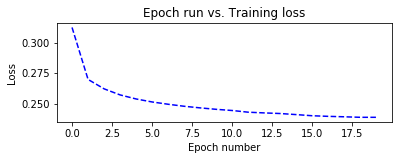

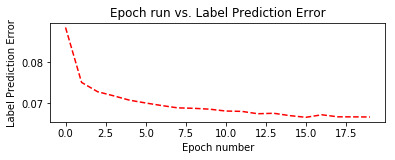

In [36]:
z3_2 = create_model(input/255.0, no_of_hidden_neurons=100)

data3_2 = train_network(z3_2, max_epochs = 20, dataset_multiplier = 1/2)

plot_data(data3_2)